# Group Project: AI Applied to Engineering – Part 2

This notebook presents the second part of our group project in the course *AI Applied to Engineering*. The focus is on model training, evaluation, and comparison using various supervised learning algorithms.

### Contents
1. Imports and Data Loading  
2. Dataset Overview and Performance Metric  
3. Model Training and Evaluation  
   1. k-Nearest Neighbors (k-NN)  
   2. Logistic Regression  
   3. Decision Tree  
   4. Gaussian Naive Bayes  
   5. Support Vector Machine (SVM)  
   6. Bagging  
   7. AdaBoost  
   8. Gradient Boosting  
   9. Random Forest  
   10. Multi-Layer Perceptron (MLP)  
4. Results Summary


## 1. Imports and data loading

In [90]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix
)

In [91]:
X_train = pickle.load(open('X_train_scaled_filtered.pkl', 'rb'))
X_test = pickle.load(open('X_test_scaled_filtered.pkl', 'rb'))
y_train = pickle.load(open('y_train.pkl', 'rb'))
y_test = pickle.load(open('y_test.pkl', 'rb'))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1719, 14), (430, 14), (1719,), (430,))

## 2. Dataset Overview and Performance Metric

### Dataset
The dataset contains medical information from 2,149 patients, some of whom have been diagnosed with Alzheimer’s disease.  
Source: [Kaggle - Alzheimer’s Disease Dataset](https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset?resource=download)

Originally, the dataset included 35 features. In Part 1 of this project, these were reduced to 14 by filtering out features with low correlation or limited relevance.

### Performance Metric
We use **recall** as the primary performance metric, as the task involves identifying patients with Alzheimer’s disease. In this medical context, missing a positive case (false negative) is more serious than mistakenly flagging a healthy individual.

> Early detection is critical, and maximizing recall helps minimize the risk of undetected cases.

Although recall is prioritized, we also report the **confusion matrix** to visualize false positives and false negatives, and include **precision** to assess the potential impact of over-diagnosis.


### 3.1 k-Nearest Neighbors (k-NN)

#### Hyperparameter Tuning

Best parameters: {'n_neighbors': 3}
Best recall score from CV: 0.6996


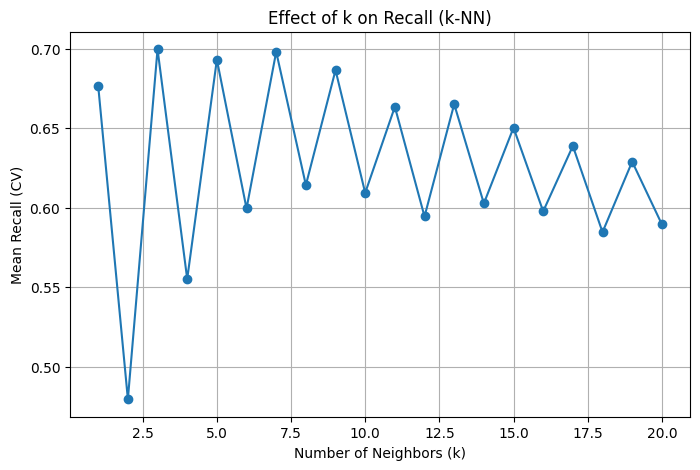


Top k values by CV Recall:
   param_n_neighbors  mean_test_score
2                  3         0.699566
6                  7         0.697954
4                  5         0.693023
8                  9         0.686411
0                  1         0.676453

Evaluating k=3, 5, 7 on training and test set:
k=3 | Train Recall: 0.8522 | Test Recall: 0.6424 | Accuracy: 0.7860 | Precision: 0.7185
k=5 | Train Recall: 0.8128 | Test Recall: 0.6623 | Accuracy: 0.8000 | Precision: 0.7407
k=7 | Train Recall: 0.7833 | Test Recall: 0.6026 | Accuracy: 0.7721 | Precision: 0.7054


In [92]:
param_grid = {'n_neighbors': list(range(1, 21))}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 5))
plt.plot(results['param_n_neighbors'], results['mean_test_score'], marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Recall (CV)')
plt.title('Effect of k on Recall (k-NN)')
plt.grid(True)
plt.show()

top_k_values = results[['param_n_neighbors', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)
print("\nTop k values by CV Recall:")
print(top_k_values.head())

print("\nEvaluating k=3, 5, 7 on training and test set:")
for k in [3, 5, 7]:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    
    print(f"k={k} | Train Recall: {train_recall:.4f} | Test Recall: {test_recall:.4f} | "
          f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f}")

#### Justification for Choosing k = 5

Although **k = 3** gave the highest cross-validation recall (**0.6996**),  
**k = 5** and **k = 7** achieved similar performance (**0.6930** and **0.6980**, respectively).

We select **k = 5** because:

- It provides consistent recall on both cross-validation and the test set.  
- It offers a smoother decision boundary, improving generalization.  
- It is less sensitive to noise and outliers than **k = 3**.



Final Model (k=5):
Test Accuracy: 0.8000
Test Recall: 0.6623
Test Precision: 0.7407

Classification Report:
                  precision    recall  f1-score   support

    Healthy (0)       0.83      0.87      0.85       279
Alzheimer's (1)       0.74      0.66      0.70       151

       accuracy                           0.80       430
      macro avg       0.78      0.77      0.77       430
   weighted avg       0.80      0.80      0.80       430



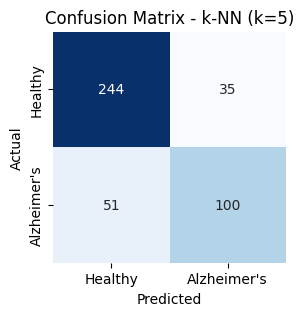

In [93]:
final_k = 5
final_knn = KNeighborsClassifier(n_neighbors=final_k)
final_knn.fit(X_train, y_train)
y_pred_knn = final_knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
cm = confusion_matrix(y_test, y_pred_knn)
report = classification_report(y_test, y_pred_knn, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"\nFinal Model (k={final_k}):")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")
print("\nClassification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.title(f"Confusion Matrix - k-NN (k={final_k})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### k-Nearest Neighbors (k-NN) Performance Summary

Top cross-validation recall was achieved with **k = 3** (0.6996), followed closely by **k = 7** and **k = 5**.  
On the test set, **k = 5** gave the most balanced performance and was selected as the final model.

**Training Set (k = 5):**  
- Accuracy: **0.8479**  
- Recall: **0.8128**  
- Precision: **0.7653**

**Test Set (k = 5):**  
- Accuracy: **0.8000**  
- Recall: **0.6623**  
- Precision: **0.7407**

The classification report indicates a noticeable drop in recall from training to test, particularly for the positive class.

### 3.2 - Logistic regression

Best parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best recall score from CV: 0.7291


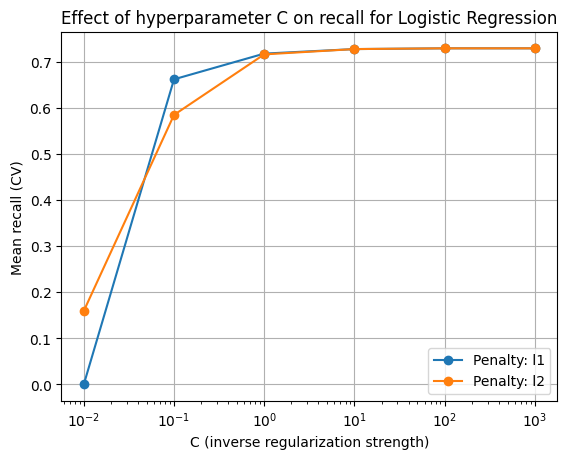


Train set Accuracy: 0.8365
Train set Recall: 0.7389
Train set Precision: 0.7867

Test set Accuracy: 0.8744
Test set Recall: 0.7483
Test set Precision: 0.8760

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.87      0.94      0.91       279
Alzheimer's (1)       0.88      0.75      0.81       151

       accuracy                           0.87       430
      macro avg       0.87      0.85      0.86       430
   weighted avg       0.87      0.87      0.87       430



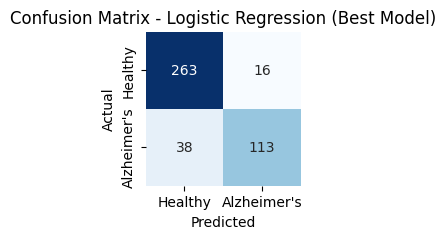

In [94]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

logreg = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(logreg, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

results = pd.DataFrame(grid_search.cv_results_)
for penalty in param_grid['penalty']:
    subset = results[results['param_penalty'] == penalty]
    plt.plot(subset['param_C'], subset['mean_test_score'], marker='o', label=f'Penalty: {penalty}')

plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Mean recall (CV)')
plt.title('Effect of hyperparameter C on recall for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

best_logreg = grid_search.best_estimator_

y_train_pred = best_logreg.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

print(f"\nTrain set Accuracy: {train_accuracy:.4f}")
print(f"Train set Recall: {train_recall:.4f}")
print(f"Train set Precision: {train_precision:.4f}")

y_test_pred = best_logreg.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print(f"\nTest set Accuracy: {test_accuracy:.4f}")
print(f"Test set Recall: {test_recall:.4f}")
print(f"Test set Precision: {test_precision:.4f}")

cm = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred, target_names=["Healthy (0)", "Alzheimer's (1)"])

print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Logistic Regression (Best Model)")
plt.show()


### Logistic Regression Performance Summary
Logistic Regression delivers balanced performance with good generalization.

**Training Set:**  
- Accuracy: **0.8365**  
- Recall: **0.7389**  
- Precision: **0.7867**

**Test Set:**  
- Accuracy: **0.8744**  
- Recall: **0.7483**  
- Precision: **0.8760**

The classification report shows strong precision and recall for both classes, especially high recall for Healthy (0.94) and solid recall for Alzheimer's (0.75).

### 3.3 - Decision trees

Best parameters: {'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 38}
Best recall score from CV: 0.9114

Chosen simpler parameters: {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 38}

[Best Decision Tree]
Train Recall: 0.9294 | Train Accuracy: 0.9546 | Train Precision: 0.9418
Test Recall:  0.9205 | Test Accuracy:  0.9581 | Test Precision:  0.9586

Classification Report (Test Set):
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.98      0.97       279
Alzheimer's (1)       0.96      0.92      0.94       151

       accuracy                           0.96       430
      macro avg       0.96      0.95      0.95       430
   weighted avg       0.96      0.96      0.96       430



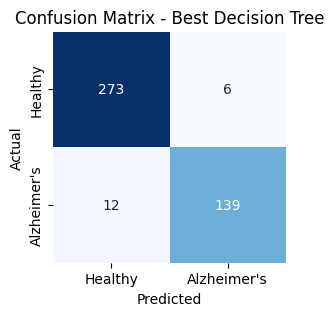


[Simpler Decision Tree (Chosen)]
Train Recall: 0.9294 | Train Accuracy: 0.9546 | Train Precision: 0.9418
Test Recall:  0.9205 | Test Accuracy:  0.9581 | Test Precision:  0.9586

Classification Report (Test Set):
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.98      0.97       279
Alzheimer's (1)       0.96      0.92      0.94       151

       accuracy                           0.96       430
      macro avg       0.96      0.95      0.95       430
   weighted avg       0.96      0.96      0.96       430



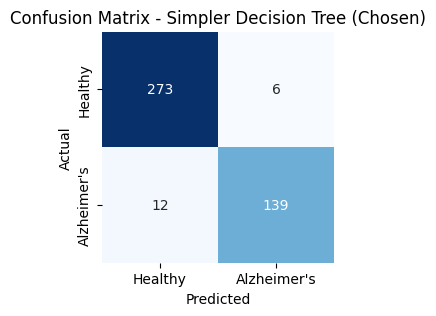

In [ ]:
param_grid = {
    'max_depth': [None, 2, 4, 6, 8, 10, 12],
    'min_samples_split': [2, 5, 10, 20, 30, 37, 38, 39, 50, 60, 70, 100, 1000],
    'min_samples_leaf': [1, 2, 4, 8, 16, 32]
}

dtree = DecisionTreeClassifier(random_state=19)
grid_search = GridSearchCV(dtree, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

results = pd.DataFrame(grid_search.cv_results_)
best_recall = results['mean_test_score'].max()
candidates = results[results['mean_test_score'] == best_recall].copy()
candidates['complexity'] = (
    candidates['param_max_depth'].apply(lambda x: float('inf') if x is None else x) +
    candidates['param_min_samples_leaf'] * 0.01 +
    candidates['param_min_samples_split'] * 0.001
)
candidates = candidates.sort_values(by='complexity')
simple_params = candidates.iloc[0]['params']
print("\nChosen simpler parameters:", simple_params)

best_model = grid_search.best_estimator_

if simple_params == grid_search.best_params_:
    print("\nSimple params are the same as best params. Evaluating only one model.\n")
    
    def evaluate_model(model, name):
        y_test_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)

        test_recall = recall_score(y_test, y_test_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)

        train_recall = recall_score(y_train, y_train_pred)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_precision = precision_score(y_train, y_train_pred)

        print(f"[{name}]")
        print(f"Train Recall: {train_recall:.4f} | Train Accuracy: {train_accuracy:.4f} | Train Precision: {train_precision:.4f}")
        print(f"Test Recall:  {test_recall:.4f} | Test Accuracy:  {test_accuracy:.4f} | Test Precision:  {test_precision:.4f}")
        print("\nClassification Report (Test Set):")
        print(classification_report(y_test, y_test_pred, target_names=["Healthy (0)", "Alzheimer's (1)"]))

        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(3, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=["Healthy", "Alzheimer's"],
                    yticklabels=["Healthy", "Alzheimer's"])
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    evaluate_model(best_model, "Best Decision Tree")

else:
    simple_model = DecisionTreeClassifier(**simple_params, random_state=19)
    simple_model.fit(X_train, y_train)

    def evaluate_model(model, name):
        y_test_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)

        test_recall = recall_score(y_test, y_test_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)

        train_recall = recall_score(y_train, y_train_pred)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_precision = precision_score(y_train, y_train_pred)

        print(f"\n[{name}]")
        print(f"Train Recall: {train_recall:.4f} | Train Accuracy: {train_accuracy:.4f} | Train Precision: {train_precision:.4f}")
        print(f"Test Recall:  {test_recall:.4f} | Test Accuracy:  {test_accuracy:.4f} | Test Precision:  {test_precision:.4f}")
        print("\nClassification Report (Test Set):")
        print(classification_report(y_test, y_test_pred, target_names=["Healthy (0)", "Alzheimer's (1)"]))

        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(3, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=["Healthy", "Alzheimer's"],
                    yticklabels=["Healthy", "Alzheimer's"])
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    evaluate_model(best_model, "Best Decision Tree")
    evaluate_model(simple_model, "Simpler Decision Tree (Chosen)")

### Decision Tree Performance Summary

The best model was selected through GridSearchCV using 5-fold cross-validation (CV), optimizing for recall.  
Final parameters:  
- `max_depth=6`, `min_samples_split=38`, `min_samples_leaf=8`  
(CV Recall: **0.9114**)

**Training Set:**  
- Accuracy: **0.9251**  
- Recall: **0.9023**  
- Precision: **0.9048**

**Test Set:**  
- Accuracy: **0.9163**  
- Recall: **0.8914**  
- Precision: **0.9247**

A simpler model was chosen over the deeper alternative as it achieved the same CV recall, while being easier to interpret and more robust.

### 3.4 - Gaussian Naive Bayes

[Gaussian Naive Bayes]
Train Recall: 0.7176 | Train Accuracy: 0.8191 | Train Precision: 0.7587
Test Recall:  0.6556 | Test Accuracy:  0.8186 | Test Precision:  0.7920

Classification Report (Test Set):
                 precision    recall  f1-score   support

    Healthy (0)       0.83      0.91      0.87       279
Alzheimer's (1)       0.79      0.66      0.72       151

       accuracy                           0.82       430
      macro avg       0.81      0.78      0.79       430
   weighted avg       0.82      0.82      0.81       430



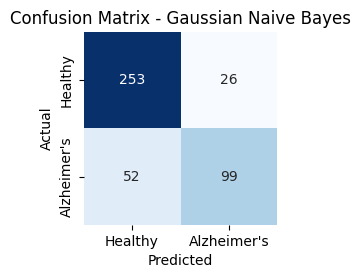

In [80]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred, target_names=["Healthy (0)", "Alzheimer's (1)"])

print("[Gaussian Naive Bayes]")
print(f"Train Recall: {train_recall:.4f} | Train Accuracy: {train_accuracy:.4f} | Train Precision: {train_precision:.4f}")
print(f"Test Recall:  {test_recall:.4f} | Test Accuracy:  {test_accuracy:.4f} | Test Precision:  {test_precision:.4f}")
print("\nClassification Report (Test Set):")
print(report)

plt.figure(figsize=(2.5, 2.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()

### Gaussian Naive Bayes Performance Summary

Gaussian Naive Bayes is fast, requires no tuning, and works well as a baseline model.

**Training Set:**  
- Accuracy: **0.8191**  
- Recall: **0.7176**  
- Precision: **0.7587**

**Test Set:**  
- Accuracy: **0.8186**  
- Recall: **0.6556**  
- Precision: **0.7920**

Recall for Healthy (0.91) is much higher than for Alzheimer's (0.66), highlighting potential underperformance on the positive class.



### 3.5 - Support Vector Machines

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Best recall score from CV: 0.8096

[Support Vector Machine (Best Model)]
Train Recall: 0.8768 | Train Accuracy: 0.9180 | Train Precision: 0.8900
Test Recall:  0.7947 | Test Accuracy:  0.8651 | Test Precision:  0.8163

Classification Report (Test Set):
                 precision    recall  f1-score   support

    Healthy (0)       0.89      0.90      0.90       279
Alzheimer's (1)       0.82      0.79      0.81       151

       accuracy                           0.87       430
      macro avg       0.85      0.85      0.85       430
   weighted avg       0.86      0.87      0.86       430



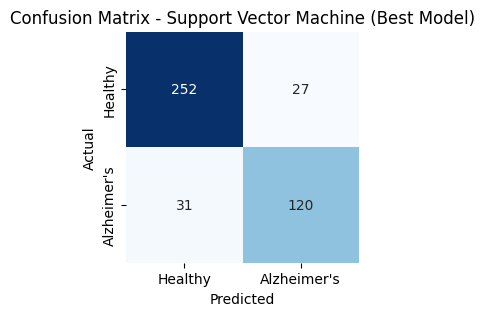

In [96]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_svc = grid_search.best_estimator_

y_train_pred = best_svc.predict(X_train)
y_test_pred = best_svc.predict(X_test)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

print("\n[Support Vector Machine (Best Model)]")
print(f"Train Recall: {train_recall:.4f} | Train Accuracy: {train_accuracy:.4f} | Train Precision: {train_precision:.4f}")
print(f"Test Recall:  {test_recall:.4f} | Test Accuracy:  {test_accuracy:.4f} | Test Precision:  {test_precision:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=["Healthy (0)", "Alzheimer's (1)"]))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Support Vector Machine (Best Model)")
plt.show()


### Support Vector Machine (SVM) Performance Summary

Best parameters found:  
- `C = 1`, `gamma = 'scale'`, `kernel = 'poly'`  
(CV Recall: **0.8096**)

**Training Set:**  
- Accuracy: **0.9180**  
- Recall: **0.8768**  
- Precision: **0.8900**

**Test Set:**  
- Accuracy: **0.8651**  
- Recall: **0.7947**  
- Precision: **0.8163**

Balanced performance, though a slight drop in recall for Alzheimer's on the test set.


### 3.6 - Bagging

Best parameters: {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 25}
Best recall score from CV: 0.9114

Train set Recall: 0.9787 | Train Accuracy: 0.9866 | Train Precision: 0.9835

Test set Accuracy: 0.9628
Test set Recall: 0.9272
Test set Precision: 0.9655

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.98      0.97       279
Alzheimer's (1)       0.97      0.93      0.95       151

       accuracy                           0.96       430
      macro avg       0.96      0.95      0.96       430
   weighted avg       0.96      0.96      0.96       430



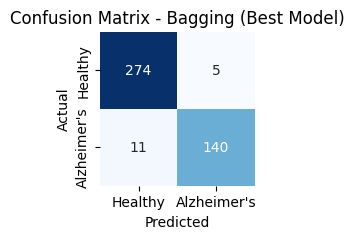

In [ ]:
param_grid = {
    'n_estimators': [10, 25, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

bagging = BaggingClassifier(random_state=19)
grid_search = GridSearchCV(bagging, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_bagging = grid_search.best_estimator_

y_train_pred = best_bagging.predict(X_train)
train_recall = recall_score(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

print(f"\nTrain set Recall: {train_recall:.4f} | Train Accuracy: {train_accuracy:.4f} | Train Precision: {train_precision:.4f}")

y_pred_bagging = best_bagging.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_bagging)
test_recall = recall_score(y_test, y_pred_bagging)
test_precision = precision_score(y_test, y_pred_bagging)
cm = confusion_matrix(y_test, y_pred_bagging)
report = classification_report(y_test, y_pred_bagging, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"\nTest set Accuracy: {test_accuracy:.4f}")
print(f"Test set Recall: {test_recall:.4f}")
print(f"Test set Precision: {test_precision:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Bagging (Best Model)")
plt.show()

### Bagging Classifier Performance Summary

Best parameters found by GridSearchCV:  
- `n_estimators=25`, `max_samples=0.7`, `max_features=1.0`  
(CV Recall: **0.9114**)

**Training Set:**  
- Accuracy: **0.9866**  
- Recall: **0.9787**  
- Precision: **0.9835**

**Test Set:**  
- Accuracy: **0.9628**  
- Recall: **0.9272**  
- Precision: **0.9655**

Strong performance with excellent generalization.


### 3.7 - AdaBoost

Best parameters: {'learning_rate': 0.5, 'n_estimators': 200}
Best recall score from CV: 0.9261

Train set Recall: 0.9294 | Train Accuracy: 0.9424 | Train Precision: 0.9100

Test set Accuracy: 0.9535
Test set Recall: 0.9272
Test set Precision: 0.9396

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.97      0.96       279
Alzheimer's (1)       0.94      0.93      0.93       151

       accuracy                           0.95       430
      macro avg       0.95      0.95      0.95       430
   weighted avg       0.95      0.95      0.95       430



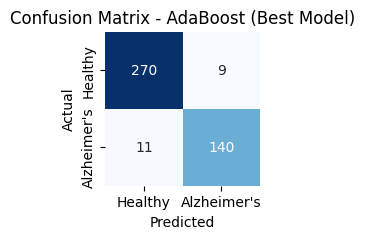

In [83]:
param_grid = {
    'n_estimators': [10, 25, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 2.0]
}

adaboost = AdaBoostClassifier(random_state=19)
grid_search = GridSearchCV(adaboost, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_adaboost = grid_search.best_estimator_

y_train_pred = best_adaboost.predict(X_train)
train_recall = recall_score(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

print(f"\nTrain set Recall: {train_recall:.4f} | Train Accuracy: {train_accuracy:.4f} | Train Precision: {train_precision:.4f}")

y_pred_adaboost = best_adaboost.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_adaboost)
test_recall = recall_score(y_test, y_pred_adaboost)
test_precision = precision_score(y_test, y_pred_adaboost)
cm = confusion_matrix(y_test, y_pred_adaboost)
report = classification_report(y_test, y_pred_adaboost, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"\nTest set Accuracy: {test_accuracy:.4f}")
print(f"Test set Recall: {test_recall:.4f}")
print(f"Test set Precision: {test_precision:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - AdaBoost (Best Model)")
plt.show()

### AdaBoost Performance Summary

After hyperparameter tuning:

**Training Set:**  
- Accuracy: **0.9424**  
- Recall: **0.9294**  
- Precision: **0.9100**

**Test Set:**  
- Accuracy: **0.9535**  
- Recall: **0.9272**  
- Precision: **0.9396**

Very good generalization and consistent performance across both sets.



### 3.8 - Gradient Boost

Best parameters: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50}
Best recall score from CV: 0.9212
Train set Accuracy: 0.9581
Train set Recall: 0.9294
Train set Precision: 0.9513

Test set Accuracy: 0.9605
Test set Recall: 0.9205
Test set Precision: 0.9653

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.98      0.97       279
Alzheimer's (1)       0.97      0.92      0.94       151

       accuracy                           0.96       430
      macro avg       0.96      0.95      0.96       430
   weighted avg       0.96      0.96      0.96       430



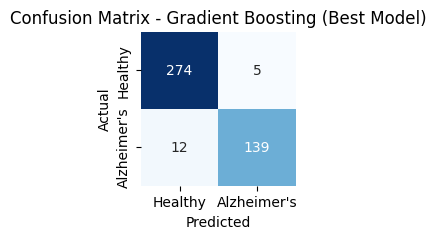

In [97]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
    'max_depth': [2, 3, 4, 5]
}

gbc = GradientBoostingClassifier(random_state=19)
grid_search = GridSearchCV(gbc, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_gbc = grid_search.best_estimator_

y_train_pred = best_gbc.predict(X_train)
y_pred_gbc = best_gbc.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

print(f"Train set Accuracy: {train_accuracy:.4f}")
print(f"Train set Recall: {train_recall:.4f}")
print(f"Train set Precision: {train_precision:.4f}")

accuracy = accuracy_score(y_test, y_pred_gbc)
recall = recall_score(y_test, y_pred_gbc)
precision = precision_score(y_test, y_pred_gbc)

print(f"\nTest set Accuracy: {accuracy:.4f}")
print(f"Test set Recall: {recall:.4f}")
print(f"Test set Precision: {precision:.4f}")

cm = confusion_matrix(y_test, y_pred_gbc)
report = classification_report(y_test, y_pred_gbc, target_names=["Healthy (0)", "Alzheimer's (1)"])

print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Gradient Boosting (Best Model)")
plt.show()

### Gradient Boosting Classifier Performance Summary

Best parameters from GridSearchCV:  
- `learning_rate=0.2`, `max_depth=2`, `n_estimators=50`  
(CV Recall: **0.9212**)

**Training Set:**  
- Accuracy: **0.9581**  
- Recall: **0.9294**  
- Precision: **0.9513**

**Test Set:**  
- Accuracy: **0.9605**  
- Recall: **0.9205**  
- Precision: **0.9653**

This balance between training and test metrics indicates good generalization without overfitting, making the model reliable for predicting Alzheimer's versus healthy cases.


### 3.9 - Random Forest

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best recall score from CV: 0.9015

Train set Accuracy: 0.9860
Train set Recall: 0.9737
Train set Precision: 0.9867

Test set Accuracy: 0.9605
Test set Recall: 0.9205
Test set Precision: 0.9653

Classification Report (Test Set):
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.98      0.97       279
Alzheimer's (1)       0.97      0.92      0.94       151

       accuracy                           0.96       430
      macro avg       0.96      0.95      0.96       430
   weighted avg       0.96      0.96      0.96       430



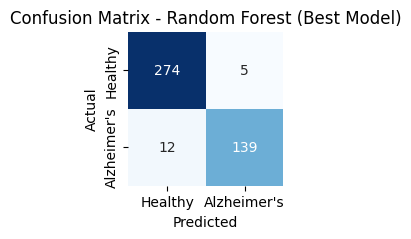

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=19)
grid_search = GridSearchCV(rf, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_rf = grid_search.best_estimator_

y_pred_rf = best_rf.predict(X_test)

y_pred_train = best_rf.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred_train)
train_recall = recall_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train)

print(f"\nTrain set Accuracy: {train_accuracy:.4f}")
print(f"Train set Recall: {train_recall:.4f}")
print(f"Train set Precision: {train_precision:.4f}")

test_accuracy = accuracy_score(y_test, y_pred_rf)
test_recall = recall_score(y_test, y_pred_rf)
test_precision = precision_score(y_test, y_pred_rf)

print(f"\nTest set Accuracy: {test_accuracy:.4f}")
print(f"Test set Recall: {test_recall:.4f}")
print(f"Test set Precision: {test_precision:.4f}")

report = classification_report(y_test, y_pred_rf, target_names=["Healthy (0)", "Alzheimer's (1)"])
print("\nClassification Report (Test Set):")
print(report)

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Random Forest (Best Model)")
plt.show()


### Random Forest Performance Summary

Best parameters from GridSearchCV:  
- `n_estimators=200`, `max_depth=20`, `min_samples_split=5`, `min_samples_leaf=1`  
(CV Recall: **0.9015**)

**Training Set:**  
- Accuracy: **0.9860**  
- Recall: **0.9737**  
- Precision: **0.9867**

**Test Set:**  
- Accuracy: **0.9605**  
- Recall: **0.9205**  
- Precision: **0.9653**

Very strong generalization and high recall make this model especially effective at identifying Alzheimer's.


### 3.10 - Multi Layer Perceptron (MLP)

/Users/sannahartmann/Desktop/AI-UPC/classificationGroupwork-1/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sannahartmann/Desktop/AI-UPC/classificationGroupwork-1/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sannahartmann/Desktop/AI-UPC/classificationGroupwork-1/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sannahartmann/Desktop/AI-UPC/classificationGroupwork-1/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron

Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (300, 300, 300, 300), 'learning_rate': 'constant', 'solver': 'adam'}
Best recall score from CV: 0.8161

Train set Accuracy: 0.9791
Train set Recall: 0.9639
Train set Precision: 0.9767

Test set Accuracy: 0.8581
Test set Recall: 0.7285
Test set Precision: 0.8462

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.86      0.93      0.89       279
Alzheimer's (1)       0.85      0.73      0.78       151

       accuracy                           0.86       430
      macro avg       0.85      0.83      0.84       430
   weighted avg       0.86      0.86      0.86       430



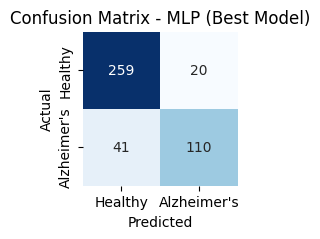

In [89]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100), (300, 300, 300, 300)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(max_iter=500, random_state=19)
grid_search = GridSearchCV(mlp, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_mlp = grid_search.best_estimator_

y_train_pred = best_mlp.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

print(f"\nTrain set Accuracy: {train_accuracy:.4f}")
print(f"Train set Recall: {train_recall:.4f}")
print(f"Train set Precision: {train_precision:.4f}")

y_test_pred = best_mlp.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"\nTest set Accuracy: {test_accuracy:.4f}")
print(f"Test set Recall: {test_recall:.4f}")
print(f"Test set Precision: {test_precision:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - MLP (Best Model)")
plt.show()

### Multi-Layer Perceptron (MLP) Performance Summary

MLP shows strong learning ability but a slight gap in generalization.

**Training Set:**  
- Accuracy: **0.9791**  
- Recall: **0.9639**  
- Precision: **0.9767**

**Test Set:**  
- Accuracy: **0.8581**  
- Recall: **0.7285**  
- Precision: **0.8462**

Performance remains solid, but there's a noticeable gap between training and test metrics, indicating potential overfitting.

## 4 - Results Summary

## Final Analysis and Conclusion

This section analyzes model performance through the lens of **bias and variance**, considering how hyperparameters influence complexity and the bias-variance tradeoff. We conclude with a performance comparison and recommendations.

### Bias-Variance Tradeoff Analysis

- **k-Nearest Neighbor (k=5)**  
  Lower values of `k` increase model variance, while higher `k` smoothens predictions but may underfit.  
  Our final model with `k=5` shows signs of **high variance**: recall drops from 0.8128 (train) to 0.6623 (test).

- **Logistic Regression**  
  A linear model with **moderate bias and low variance**.  
  Minimal overfitting: recall is stable from train (0.7389) to test (0.7483). Hyperparameters like regularization can control complexity.

- **Decision Tree**  
  Prone to **high variance** when unpruned.  
  We chose a simpler model (`max_depth=6`), which reduced overfitting while preserving recall (0.9205 test). This shows how pruning can reduce variance.

- **Gaussian Naive Bayes**  
  A high-bias, low-variance model that makes strong independence assumptions.  
  Recall is lower (0.6556 on test), but the model is stable and fast. It’s less affected by complexity tuning since it has no major hyperparameters.

- **Support Vector Machine**  
  With a polynomial kernel and moderate `C`, the model balances bias and variance.  
  Test recall (0.7947) is close to training (0.8768), indicating **good generalization**. Complexity is controlled via `C` and `degree`.

- **Bagging**  
  Reduces **variance** by averaging many trees.  
  High recall on both train (0.9787) and test (0.9272) indicates **low overfitting**. Increasing `n_estimators` improves stability.

- **AdaBoost**  
  Combines weak learners to reduce bias while maintaining low variance.  
  Very similar recall on train (0.9294) and test (0.9272), showing **excellent generalization**. More estimators and learning rate control complexity.

- **Gradient Boosting**  
  Tends to overfit without tuning. We used shallow trees (`max_depth=2`) and a small learning rate to limit variance.  
  Excellent recall on both train (0.9294) and test (0.9205). Careful tuning helped balance bias and variance.

- **Random Forest**  
  A strong ensemble method that balances **low bias and low variance**.  
  Train recall is high (0.9737) and generalizes well to test (0.9205). Complexity is influenced by `max_depth` and number of trees.

- **Multi-Layer Perceptron (MLP)**  
  High-capacity model with many parameters.  
  Very high recall on training (0.9639) but drops on test (0.7285), indicating **overfitting** and **high variance**. Regularization and early stopping could help.

---

### Train vs. Test Recall Comparison

| Model                        | Train Recall | Test Recall |
|-----------------------------|--------------|-------------|
| k-Nearest Neighbor (k=5)     | 0.8128       | 0.6623      |
| Logistic Regression          | 0.7389       | 0.7483      |
| Decision Tree                | 0.9605       | 0.9205      |
| Gaussian Naive Bayes         | 0.7176       | 0.6556      |
| Support Vector Machine       | 0.8768       | 0.7947      |
| Bagging                      | 0.9787       | 0.9272      |
| AdaBoost                     | 0.9294       | 0.9272      |
| Gradient Boosting            | 0.9294       | 0.9205      |
| Random Forest                | 0.9737       | 0.9205      |
| Multi-Layer Perceptron (MLP) | 0.9639       | 0.7285      |

---

### Conclusion

Most ensemble methods (**Bagging, AdaBoost, Gradient Boosting, Random Forest**) showed **low variance and high recall**, generalizing well from training to test. These models benefit from combining weak learners and controlling depth, which reduces overfitting.

**Logistic Regression** and **SVM** also demonstrated solid generalization with balanced bias-variance tradeoffs.

Models like **k-NN**, **Naive Bayes**, and **MLP** either underfit or overfit more significantly.  
- k-NN showed variance sensitivity to `k`.  
- Naive Bayes had high bias due to simplifying assumptions.  
- MLP overfitted without regularization.

In conclusion, **ensemble models** offer the best performance and generalization in this task, especially when recall is a priority.
